<a href="https://colab.research.google.com/github/stefanogiagu/AI_INFN/blob/main/2025/MoE_GT_BaseExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture-of-experts graph transformers for interpretable particle collision detection

*2nd AI_INFN Hachathon - Pavia 24-27/11/2025*

**Base exercise:** run the notebook, implement python/pytorch code for the performance/intepretability evaluation tasks, test the model with blation studies

**Topic:** MoE GraphTransformers (D.Genovese, A.Sgroi, A.Devoto, S.Valentine, L.Wood, C.Sebastiani, S.Scardapane, M.D'Onofrio, S.Giagu,  "Mixture-of-experts graph transformers for interpretable particle collision detection", [Sci Rep 15, 27906 (2025)](https://link.springer.com/article/10.1038/s41598-025-12003-9)), combine a Graph Transformer model ([arXiv:2021.09699](https://arxiv.org/abs/2012.09699)) with Mixture-of-Expert layers ([arXiv:1701.06538](https://arxiv.org/abs/1701.06538)) to achieve high predictive performance while embedding explainability into the architecture.

**Example application:** Classification of high energy decays (Exotic Higgs decays $H^0(425) \to WH^+(325) \to WWh^0(125)\to WWb\bar{b}\to l\nu qq'b\bar{b}$ final states, vs SM $t\bar{t}\to WWb\bar{b}\to l\nu qq'b\bar{b}$). **Public dataset** from  P.Baldi, P.Sadowsky, D. Whiteson, "Searching for exotic particles in high-energy physics with deep learning", [Nat Commun 5, 4308 (2014)](https://www.nature.com/articles/ncomms5308).

**Notebook steps:**
1. read and preprocess dataset to create events fully connected graphs (sets), with Laplacian spectral positional encoding ([arXiv:2106.03893](https://arxiv.org/pdf/2106.03893));
2. design a MoE Graph-Transformer (MoE-GT) architecture;
3. training and performance assesment;
4. exaple of analysis of the experts' utilisation and of the attention heat-maps.

**Exercise steps:**
1. train the model
2. evaluate model perfromance and use the interpretability tools, by completing the writing of the code needed to implement the cells 7, 8, 9, and 10.
3. play with the model parameters, changing number of experts; removing the load balancing auxilary loss; removing the Laplacian positional embedding, checking the effect on the model performance

**Note:** set and coded to be fully run (train + test) in less than ~30 minutes on gogle colab using a Nvidia T4 GPU

**Notebook Version:** V1.1 **author:** <stefano.giagu@uniroma1.it>

In [ ]:
#@title 1. Setup software [average running time in google colab: ~50 seconds]
import torch
print(torch.__version__)


#install pytorch geometric libraries in google colab
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster torch-spline-conv --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 114.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 65.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.4 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-06riwbx5
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-06riwbx5
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 2f182dc6fde74bb04a67b5812dd5ee94aaf92092
  Installing build dependencies ... done
  Getting requirements to bui

In [ ]:
#@title 2. Import libraries [average running time in google colab: ~1 second]
import math, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Torch', torch.__version__, '| device →', device)

Torch 2.8.0+cu126 | device → cuda


### Higgs Dataset  
From the paper:  
**“Searching for exotic particles in high-energy physics with deep learning”**,  
P. Baldi, P. Sadowski, D. Whiteson, *Nature Communications* **5**, 4308 (2014).

---

### **Dataset Description**

The dataset contains **24 features**, corresponding to kinematic quantities of leptons, missing energy, and jets, plus reconstructed masses.

#### **Lepton variables**
- Transverse momentum: $( p_T^{\ell} )$  
- Pseudorapidity: $( \eta^{\ell} )$  
- Azimuthal angle: $( \phi^{\ell} )$

#### **Missing transverse energy**
- Magnitude: $( E_T^{\text{miss}} )$  
- Direction: $( \phi^{\text{miss}} )$

#### **Jets** $(( j_1, j_2, j_3, j_4 ))$
For each jet $( j_i )$:
- Transverse momentum: $( p_T^{j_i} )$  
- Pseudorapidity: $( \eta^{j_i} )$  
- Azimuthal angle: $( \phi^{j_i} )$  
- b-tag value: $( b^{j_i} )$

#### **Reconstructed masses**
- $( m_{bb} )$  
- $( m_{Wbb} )$  
- $( m_{WWbb} )$

---

### **Feature Preprocessing**

- All features were **standardized** over the full training / test set:
  $[
  x' = \frac{x - \mu}{\sigma},
  ]$
  where $( \mu = 0 )$ and $( \sigma = 1 )$.

- **Exception**:  
  Features with **strictly positive** values (i.e., $( x > 0 )$ for all samples) were **rescaled** such that their mean equals 1:
  $[
  \frac{1}{N} \sum_i x'_i = 1.
  ]$

---


In [ ]:
#@title 3. Load `data_HiggsDS.npz` & create splits & [average running time in google colab: ~10 seconds]

# download dataset (numpy compressed)
!wget -N http://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz

npz = np.load('data_higgsDS.npz')
X_all = npz['features'].astype('float32')
y_all = npz['labels'  ].astype('int64')

print('Dataset shape:', X_all.shape)

# train / val / test = 80 / 10 / 10 %
n   = 400000 #number of events used for the exercises (kept low to reduce running time)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val


idx   = np.random.permutation(len(X_all))
X_all = X_all[idx];  y_all = y_all[idx]

X_all = X_all[:n]
y_all = y_all[:n]

print('Used dataset shape:', X_all.shape, '\n')

print('Split sizes:', n_train, n_val, n_test)

# standardisation on train only
scaler = StandardScaler().fit(X_all[:n_train])
X_all  = scaler.transform(X_all).astype('float32')

--2025-08-22 09:05:28--  http://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.50.104, 188.185.5.88, 137.138.55.232, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz [following]
--2025-08-22 09:05:29--  https://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132168641 (126M)
Saving to: ‘data_higgsDS.npz’

data_higgsDS.npz    100%[===================>] 126.04M  22.4MB/s    in 6.9s    

2025-08-22 09:05:36 (18.2 MB/s) - ‘data_higgsDS.npz’ saved [132168641/132168641]

Dataset shape: (1691147, 24)
Used dataset shape: (400000, 24) 

Split sizes: 320000 40000 40000


### Laplacian Positional Encoding  

### **Motivation**

Transformers rely on **token order** to understand the structure of a sequence. Graphs, however, are **unordered** collections of nodes: there is no inherent “first” or “last” node.

To use transformers (e.g., Graph Transformers) on graphs, we assign each node a **coordinate vector** that represents its location within the graph’s topology.  These coordinates are known as **graph positional encodings (PEs)**.

A powerful method for generating such coordinates is the **Laplacian Positional Encoding (LPE)**, which uses the *spectral properties* of a graph to extract its global structure.

---

### **Graph Laplacian: Definition**

Given an undirected graph  
$[G = (V, E), \qquad |V| = N,]$
define:

- **Adjacency matrix**
  $
  A_{ij} =
  \begin{cases}
  1, & (i,j) \in E, \\
  0, & \text{otherwise},
  \end{cases}
  $

- **Degree matrix**
  $
  D = \mathrm{diag}(d_1, \ldots, d_N), \qquad d_i = \sum_j A_{ij}.
  $

The **combinatorial Laplacian** is then defined as:
$L = D - A$.

Properties:
- $L$ is **symmetric** and **positive semidefinite**;
- it plays a role analogous to the continuous **Laplacian operator** (second derivative).

---

### **Spectral Decomposition**

The Laplacian admits an eigen-decomposition:
$ L u_k = \lambda_k u_k, \qquad
0 = \lambda_0 \le \lambda_1 \le \dots \le \lambda_{N-1}.
$
<p>
<p>

- $( u_0 = \frac{1}{\sqrt{N}} (1, \dots, 1)^T )$ is the trivial constant eigenvector.
- $( u_1, \dots, u_{N-1} )$ form an **orthonormal basis** on the graph (analogous to Fourier modes such as sines and cosines).

---

### **Laplacian Positional Encoding Procedure**

1. Choose a small number $( k )$ (typically $\in (4, 16)$).
2. Take the first $( k )$ **non-trivial** eigenvectors:
   $
   \text{PE} = [u_1, \dots, u_k] \in \mathbb{R}^{N \times k}.
   $
3. For each node $( i )$, define its $k-$dimensional positional encoding: $\text{PE}_i = (u_1(i), \dots, u_k(i)).$

---

### **Advantages of LPE**

- Provides a **geometry-aware** notion of position, not tied to an arbitrary node ordering.
- Low-frequency eigenvectors vary slowly across the graph → capture **coarse clusters** and **long-range dependencies**.
- Laplacian depends only on the graph structure → PE is **permutation-equivariant**:
  - reorder nodes → rows permute → transformer still sees the same geometry.
- Improves model expressiveness:
  - LPEs allow transformers to distinguish graphs that message-passing GNNs cannot (enhances representational power / capacity of the model).

---

In [ ]:
# Laplacian positional encoding [average running time in google colab: ~0 seconds]


# function that returns (N, k) matrix of Laplacian eigenvectors
def laplacian_pe(num_nodes=24, k=4):
    A = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes)  # fully-connected (matrix with all 1s but the diagonal)
    D = torch.diag(A.sum(1))
    L = D - A
    eigvals, eigvecs = torch.linalg.eigh(L)         # (N,), (N,N)
    return eigvecs[:, 1:k+1].float()                # drop the trivial eigenvector
PE_FIXED = laplacian_pe()                           # shape (24, 4)

In [ ]:
#@title 4. PyTorch Dataset & DataLoaders [average running time in google colab: ~0 seconds]

class HiggsGraphDataset(Dataset):
#Treat each event as a fully-connected graph with 24 nodes, one scalar feature per node.
    def __init__(self, X, y, pe=PE_FIXED):
        self.X = X.reshape(-1, 24, 1)    # (B, N=24, F=1)
        #Laplacian PE
        self.pe = pe.unsqueeze(0).repeat(len(X), 1, 1)  # broadcast to batch
        self.y = y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        x_node = torch.from_numpy(self.X[i])        # (N,1)
        x = torch.cat([x_node, self.pe[i]], dim=-1) # now (N, 1+pe_dim)
        return x, torch.tensor(self.y[i])

ds_train = HiggsGraphDataset(X_all[:n_train], y_all[:n_train])
ds_val   = HiggsGraphDataset(X_all[n_train:n_train+n_val], y_all[n_train:n_train+n_val])
ds_test  = HiggsGraphDataset(X_all[n_train+n_val:n_train+n_val+n_test], y_all[n_train+n_val:n_train+n_val+n_test])

train_loader = DataLoader(ds_train, batch_size=1024, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(ds_val,   batch_size=4096, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(ds_test,  batch_size=4096, shuffle=False, num_workers=2, pin_memory=True)

print(f'Events → train:{len(ds_train)}  val:{len(ds_val)}  test:{len(ds_test)}')

Events → train:320000  val:40000  test:40000


### Graph Transformer + Mixture-of-Experts (MoE) Architecture

---

### **Architecture Overview**

The Mixture-of-Experts (MoE) mechanism augments a Graph Transformer by routing each token to a **subset** of experts, rather than passing all tokens through a single feed-forward network.

Below is a schematic representation:

```text
        token features (T, d_model)
                      │
           ┌──────────┴──────────┐
           ▼                     ▼
   Noisy-Top-K router      load-balancing
 (select k experts/token)       loss
           │
           ├── indices  ───────────────►  (analysis only)
           └── gates   ┐
                       ▼
        ┌───────────────────────────────┐
        │   Expert 0   Expert 1   ...   │   (E experts in parallel)
        │      MLP        MLP           │
        └───────────────────────────────┘
                       ▲
          weighted sum │   (sparse: only k experts/token)
                       ▼
          combined output (T, d_model)
                       │
           residual connection + LayerNorm
```

---

### **Router: Core Component of the MoE**

The **router** is the heart of the Mixture-of-Experts architecture.  
Its role is to decide, **for each token**, which subset of experts it should be routed to, and with what **importance** (the gating weights).

The router implements a gating function:

$G(x) = \mathrm{Softmax}\!\big(\mathrm{KeepTopK}(H(x), k)\big),$

where:

- $( x )$ is the token representation,
- $( H(x) )$ is a learned scoring function (plus injected noise),
- $( k )$ is the number of experts selected per token.

The noise term encourages exploration and prevents all tokens from collapsing onto the same experts too early during training.

---

### **Noisy-Top-K Router: Steps**

The `NoisyTopKRouter` module conceptually performs the following operations:

1. **Score assignment**  
   For each token $( x )$, compute a score for every expert:
   $[
   H_j(x) \qquad j = 1, \dots, E.
   ]$

2. **Noise injection**  
   Add random noise (typically Gaussian) to the scores to encourage diverse routing.

3. **Top-k selection**  
   Select the $( k )$ highest-scoring experts for each token.

4. **Softmax over selected experts**  
   Normalize the scores of the selected experts to obtain the routing weights:
   $[
   g_j(x) = \frac{\exp(H_j(x))}{\sum_{\ell \in \text{Top-}k} \exp(H_{\ell}(x))},
   \quad j \in \text{Top-}k.
   ]$

5. **Load-balancing auxiliary loss**  
   Produce an additional loss term that encourages tokens to be spread across experts (avoiding **expert collapse**, where only a few experts are used).

---

### **Experts in the Mixture-of-Experts Layer**

In a Mixture-of-Experts layer, each input token is routed to a **small subset** of experts—typically only **two**.  
Unlike a standard Transformer, where all tokens pass through the same feed-forward network, the **router** determines which expert(s) should process each token.

Each **expert** is implemented as an independent **2-layer MLP** with a LeakyReLU activation function:

- experts **do not share parameters**,  
- each expert learns a **specialized transformation** on the tokens routed to it.

Because different tokens may choose different experts, the system processes tokens **in batches**, ensuring efficient GPU utilization even with sparse, token-specific routing decisions.

---

### **Combined Expert Output**

Each token is processed only by its top-$k$ experts. The outputs of those experts are aggregated as a **sparse weighted sum**:
$
y(x) = \sum_{j \in \text{Top-}k} g_j(x) \, \mathrm{Expert}_j(x).
$

The final MoE block output is:

- the **combined expert output** of shape $( (T, d_{\text{model}}) )$,
- followed by a **residual connection**:
  $[
  x + y(x)
  ]$
- and then **Layer Normalization**.

---

In [ ]:
#@title 5. Graph-Transformer + Mixture-of-Experts Architecture [average running time in google colab: ~0 seconds]

# Architecture scheme:
#
#          token features (T, d_model)
#                     │
#          ┌──────────┴──────────┐
#          ▼                     ▼
#   Noisy-Top-K router       load-balancing
#(select k experts/token)        loss
#          │
#          ├── indices  ─────────► (analysis only)
#          └── gates   ┐
#                      ▼
#        ┌───────────────────────────┐
#        │  Expert 0   Expert 1  …   │   (E experts in parallel)
#        │   MLP        MLP          │
#        └───────────────────────────┘
#                      ▲
#         weighted sum │ (sparse: only k experts/tok)
#                      ▼
#         combined output (T, d_model)
#                      │
#          residual + LayerNorm, etc.



# ---------- Router --------------------------------------------------------------
# router scope: is the heart of the MoE architecture. His task is to decide,
# for each token, which subset of experts it should be routed to, and with what
# importance (the so called gating weights).

# In practice implements the function G(x): G(x) = Softmax(KeepTopK(H(x),k)) in which
# H(x) is a score function that includes learned expert scores plus noise. This allows the model
# to learn during traning which experts are relevant for a token and encourages diverse routing.

# the NoisyTopKRouter module implements the following steps:
# 1: assigns a score to each expert for every token
# 2: adds noise to encourage exploration
# 3: selects the top-k scoring experts
# 4: applies a softmax to produce routing weights
# 5: outputs an auxiliary load-balancing loss, in order to avoid expert collapse

#
class NoisyTopKRouter(nn.Module):
    def __init__(self, d_model, n_experts, k=2, w_load=1.0):
        super().__init__()
        self.k, self.w_load = k, w_load #k and weight for the load balancing loss
        self.wg     = nn.Linear(d_model, n_experts, bias=False) #linear projection: score how well each expert fits the token (learned scores)
        self.w_noise= nn.Linear(d_model, n_experts, bias=False) #learn a noise scale per expert, per token

    def forward(self, x):
        # input: x (T, d) <- token embedding
        # outputs:
        #   gates: (T, k)     <- softmax weights for top-k experts
        #   indices: (T, k)   <- which experts were selected
        #   lb_loss: scalar   <- load-balancing loss
        logits  = self.wg(x) # linear projection: score how well each expert fits the token
        noise   = torch.randn_like(logits)
        logits += F.softplus(self.w_noise(x)) * noise  #encourages exploration during training, avoids premature convergence to a few experts

        # select top-k experts
        topk_log, topk_idx = torch.topk(logits, self.k, -1) # (T,k) select the best k experts for this token
        gates = F.softmax(topk_log, -1)                     # (T,k) Compute routing weights among those k experts

        # Compute load-balancing loss to ensure the even utilization of the experts
        probs   = torch.sigmoid(logits - topk_log[:, [-1]]) # P(x,i)
        loads   = probs.sum(0) # total load per expert
        lb_loss = self.w_load * loads.var() / (loads.mean()**2 + 1e-9)  # Eq.(6) encourages equal usage of all experts (so some don't die out)

        return gates, topk_idx, lb_loss

# ---------- Experts -------------------------------------------------------------
# expert scope: in a MoE layer each input token is routed to a small subset (typically just two)
# of parallel neural networks called experts. Instead of every token passing through a single shared
# feed-forward network as in a normal Transformer, the router module decides which expert(s) should process
# which tokens.
# Each expert is a 2-layers MLP with LeakyReLU non-linearity, and it is a stanadlone MLP (eg parameters are not shared
# across experts)

# NOTE: tokens are processed batch-wise so that GPU utilisation remains efficient even when different tokens choose
# different experts.

class Expert(nn.Module):
    def __init__(self, d_model, d_hidden=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_hidden), #expansion (like in stadard transformers)
            nn.LeakyReLU(inplace=True),   #non-linearity
            nn.Linear(d_hidden, d_model)  #projecton back
        )
    def forward(self, x): return self.net(x)

# ---------- MoE -----------------------------------------------------------------
class MoE(nn.Module):
    def __init__(self, d_model, n_experts=6, k=2, d_hidden=20):
        super().__init__()
        self.router  = NoisyTopKRouter(d_model, n_experts, k)
        self.experts = nn.ModuleList([Expert(d_model, d_hidden) for _ in range(n_experts)])

    def forward(self, x, trace=False):
        gates, idx, lb_loss = self.router(x)             # (T,k)
        y = torch.zeros_like(x)

        for hop in range(gates.size(1)):
            e_idx = idx[:, hop]
            for e in range(len(self.experts)):
                sel = e_idx == e
                if sel.any():
                    y[sel] += gates[sel, hop:hop+1] * self.experts[e](x[sel])

        return (y, lb_loss, (gates.detach(), idx.detach())) if trace else (y, lb_loss)
# ---------- Attention block -----------------------------------------------------
class GraphMultiHeadAttention(nn.Module):
    def __init__(self, d_model, heads):
        super().__init__()
        assert d_model % heads == 0
        self.dk, self.h = d_model // heads, heads
        self.q = nn.Linear(d_model, d_model); self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model); self.o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):                      # x (B,N,d)
        B,N,_ = x.size(); h,dk = self.h,self.dk
        q = self.q(x).view(B,h,N,dk)
        k = self.k(x).view(B,h,N,dk)
        v = self.v(x).view(B,h,N,dk)
        attn = (q @ k.transpose(-1,-2)) / math.sqrt(dk)
        if mask is not None: attn = attn.masked_fill(mask[:,None]==0, -1e9)
        attn = attn.softmax(-1)
        return self.o((attn @ v).transpose(1,2).reshape(B,N,-1)), attn   # return attn for explain
# ---------- Graph Transformer block ---------------------------------------------------
# NOTE: when the model is executed with: model(sample_x, explain=True), it returns the attention matrices from every
# Transformer layer and every attention head, and the MoE routing traces, which include the per-token gate weights, and
# the **top-k expert indices** chosen by the router. These diagnostic tensors are **not** used during normal inference;
# they are enabled only for inspection and explainability.

class GTBlock(nn.Module):
    def __init__(self, d_model=64, heads=2, n_experts=6, k=2, d_expert=20, p_drop=0.):
        super().__init__()
        self.attn  = GraphMultiHeadAttention(d_model, heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.moe   = MoE(d_model, n_experts, k, d_expert)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop  = nn.Dropout(p_drop)

    def forward(self, x, mask=None, explain=False):
        attn_out, attn_map = self.attn(x, mask)
        x = self.norm1(x + self.drop(attn_out))
        if explain:
            y, lb, rt = self.moe(x.flatten(0,1), trace=True)
            y = y.view_as(x); x = self.norm2(x + self.drop(y))
            return x, lb, attn_map.detach(), rt
        else:
            y, lb = self.moe(x.flatten(0,1))
            y = y.view_as(x); x = self.norm2(x + self.drop(y))
            return x, lb
# ---------- Complete model ------------------------------------------------------
class GraphTransformerMoE(nn.Module):
    def __init__(self, in_dim=5, d_model=64, layers=2, heads=2,
                 n_experts=6, k=2, d_expert=20):
        super().__init__()
        self.in_proj = nn.Linear(in_dim, d_model)
        self.blocks  = nn.ModuleList([
            GTBlock(d_model, heads, n_experts, k, d_expert) for _ in range(layers)
        ])
        self.cls_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )

    def forward(self, x, mask=None, explain=False):
        # x (B,N,1)
        x = self.in_proj(x)
        lb_losses, atts, rts = [], [], []
        for blk in self.blocks:
            if explain:
                x, lb, att, rt = blk(x, mask, explain=True)
                atts.append(att); rts.append(rt)
            else:
                x, lb = blk(x, mask)
            lb_losses.append(lb)
        g = x.mean(1)                 # global mean pooling
        return self.cls_head(g), torch.stack(lb_losses).mean(), (atts, rts) if explain else None

In [ ]:
#@title 6. Training loop [average running time in google colab for 60 epochs: ~25-30 min on T4 GPU]

import time
# instantiate model and define loss, optimizer, and scheduler
model = GraphTransformerMoE().to(device)

crit  = nn.CrossEntropyLoss() #x-entropy loss
opt   = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5) #AdamW
sched = CosineAnnealingLR(opt, T_max=60) #cosine learning rate scheduler

num_epochs = 60

best_val = 1e9; best_state = None
history = {'train':[], 'val':[]}

# ---- epoch loop ------------------------------------------------------------
for epoch in range(1, num_epochs+1):
    t0 = time.time()

    # ---- train loop --------------------------------------------------------
    model.train(); running = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits, lb, _ = model(xb) #model prediction
        loss = crit(logits, yb) + lb #compute loss
        opt.zero_grad(); loss.backward(); opt.step() #bakprop and weight update
        running += loss.item() * yb.size(0)
    sched.step()

    # ---- validation loop ----------------------------------------------------
    model.eval(); val_loss = 0
    correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, lb, _ = model(xb)
            loss = crit(logits, yb) + lb
            val_loss += loss.item() * yb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item(); total += yb.size(0) #accuracy

    train_loss = running / len(ds_train)
    val_loss   = val_loss / len(ds_val)
    val_acc    = correct / total
    history['train'].append(train_loss); history['val'].append(val_loss)

    # save best model
    if val_loss < best_val:
        best_val, best_state = val_loss, model.state_dict()

    elapsed_time = time.time()-t0

    print(f'Epoch {epoch:02d} | time {elapsed_time:.2f} | train loss {train_loss:.4f} | val loss {val_loss:.4f} | val acc {val_acc:.3f}')

Epoch 01 | time 25.77 | train loss 0.6505 | val loss 0.6112 | val acc 0.665
Epoch 02 | time 25.36 | train loss 0.5998 | val loss 0.5940 | val acc 0.684
Epoch 03 | time 25.42 | train loss 0.5884 | val loss 0.5830 | val acc 0.694
Epoch 04 | time 32.95 | train loss 0.5834 | val loss 0.5804 | val acc 0.695
Epoch 05 | time 26.01 | train loss 0.5806 | val loss 0.5780 | val acc 0.695
Epoch 06 | time 25.56 | train loss 0.5777 | val loss 0.5755 | val acc 0.699
Epoch 07 | time 25.34 | train loss 0.5768 | val loss 0.5759 | val acc 0.698
Epoch 08 | time 29.97 | train loss 0.5748 | val loss 0.5715 | val acc 0.700
Epoch 09 | time 26.26 | train loss 0.5735 | val loss 0.5756 | val acc 0.699
Epoch 10 | time 25.15 | train loss 0.5724 | val loss 0.5704 | val acc 0.700
Epoch 11 | time 25.33 | train loss 0.5707 | val loss 0.5682 | val acc 0.702
Epoch 12 | time 25.96 | train loss 0.5695 | val loss 0.5683 | val acc 0.703
Epoch 13 | time 25.64 | train loss 0.5680 | val loss 0.5673 | val acc 0.704
Epoch 14 | t

In [ ]:
#@title 7. Test metrics [average running time in google colab for 60 epochs: ~2 sec]
model.load_state_dict(best_state)
model.eval(); correct = total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits, _, _ = model(xb)
        correct += (logits.argmax(1) == yb).sum().item(); total += yb.size(0)
print('Test accuracy:', correct/total)

Test accuracy: 0.70975


### **ROC Curve and AUC Evaluation**

The following code block computes and visualizes the **Receiver Operating Characteristic (ROC)** curve for the model on the test set, as well as the corresponding **Area Under the Curve (AUC)** score.

**Steps performed:**

1. **Switch to evaluation mode**  
   The model is set to `eval()` to disable dropout and other training-specific behaviors.

2. **Collect true labels and prediction scores**  
   For every batch in the test loader:
   - the inputs are moved to the appropriate device,
   - the model outputs the logits,
   - a softmax is applied to obtain class probabilities,
   - the probability of the positive class (`P(class = 1)`) is stored,
   - the ground-truth labels are recorded.

3. **Flatten the stored results**  
   The lists of labels and prediction scores are concatenated into NumPy arrays.

4. **Compute ROC curve**  
   Using `roc_curve`, the code extracts:
   - **FPR** (false positive rate),
   - **TPR** (true positive rate),
   - the decision **thresholds**.

5. **Compute AUC score**  
   With `roc_auc_score`, the overall AUC value is computed.  
   AUC measures how well the model ranks positive vs. negative samples (1.0 = perfect).

6. **Plot the ROC curve**  
   The code creates a figure showing:
   - the ROC curve (`TPR` vs. `FPR`),
   - the diagonal “chance” line,
   - axis limits, labels, title, and legend.

7. **Print the AUC**  
   The final AUC score on the test set is printed.

This analysis provides an important measure of **binary classification performance**, independent of any specific threshold.


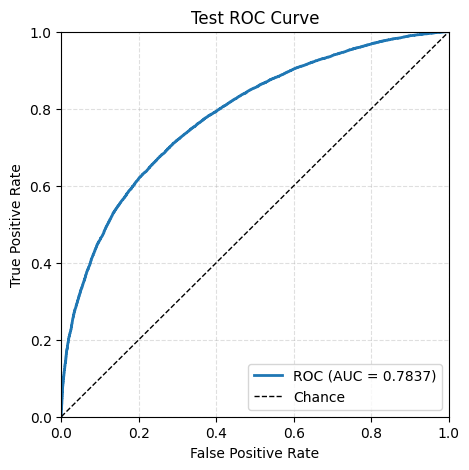

AUC (test): 0.783735


In [ ]:
# ROC/AUC Curve:

# Exercise: write down the code that implement the ROC curve perfomance metrics as described above
# suggestion: use roc_curve and roc_auc_score from sklearn.metrics

from sklearn.metrics import roc_curve, roc_auc_score


# WRITE THE NEEDED CODE HERE ...

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {auc_value:.4f})')
plt.plot([0,1], [0,1], 'k--', lw=1, label='Chance')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc='lower right'); plt.grid(True, ls='--', alpha=0.4)
plt.show()

print(f"AUC (test): {auc_value:.6f}")

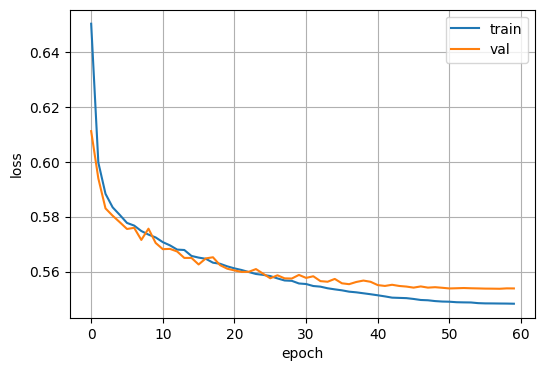

In [ ]:
#@title 8. Plot training / validation loss [average running time in google colab for 60 epochs: ~0 sec]


# Exercise: write down the matplotlib code to plot the traingin curves (loss for training and validation sets) as
# a function of the trainign epochs

# WRITE THE NEEDED CODE HERE ...

### **Expert Utilisation Histogram (Validation)**

The follwining code block evaluates how frequently each expert in the final MoE layer is selected during validation. It provides insight into **expert load balance**, helping detect **expert collapse** (when only a few experts get used).

---

### **What the code does**

1. **Set model to evaluation mode**  
   Ensures deterministic behavior and disables dropout.

2. **Iterate over the validation set**  
   For each batch:
   - move inputs to the correct device,
   - run a forward pass with `explain=True` to retrieve **routing traces**.

3. **Extract routing information**  
   From the last MoE layer:
   - `gates` → gating weights for each token (shape $(T \times k)$),  
   - `idx` → expert indices selected by the router (shape $(T \times k)$).

4. **Determine the chosen expert for each token**  
   For every token, select the expert with the **highest gate weight**:
   $[
   \text{expert}(t) = \arg\max_j \; g_{t,j}
   ]$
   where $(g_{t,j})$ is the gate weight for expert $(j)$ for token $(t)$.

   This returns a single expert ID per token.

5. **Accumulate expert assignments**  
   All expert IDs across validation batches are collected into a list.

6. **Count expert usage**  
   A histogram is computed using `torch.bincount`:
   - `num_exp` = total number of experts,
   - `counts[i]` = number of tokens routed to expert $(i)$.

7. **Plot the histogram**  
   A bar chart visualizes:
   - expert IDs on the x-axis,  
   - number of routed tokens on the y-axis.

   The plot title **“Validation expert utilisation”** highlights how load is distributed among experts.

---

### **Why this is useful**

- **Balanced expert usage** ensures efficient training.  
- **Collapsed experts** (experts that receive almost no tokens) indicate a routing problem and may require:
  - adjusting load-balancing loss,
  - tuning noise in the router,
  - increasing diversity regularization.

This visualization is an essential diagnostic tool when training Mixture-of-Experts models.


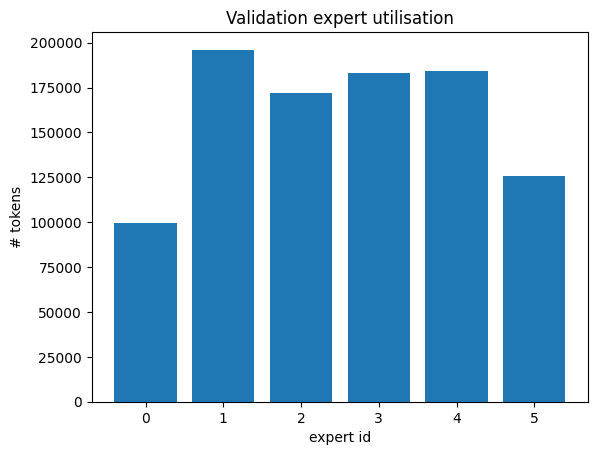

In [ ]:
#@title 9. Expert-utilisation histogram (validation) [average running time in google colab for 60 epochs: ~1 sec]


# Exercise: write the code to visualize the expert utilizzation hoistograms on the validation set
# follows the code description in the text cell above

# WRITE THE NEEDED CODE HERE ...

plt.bar(range(num_exp), counts)
plt.xlabel('expert id'); plt.ylabel('# tokens')
plt.title('Validation expert utilisation')
plt.show()

### **Explainability: Attention Heat-Map & Expert Assignment for a Single Event**

This block provides an example of an **interpretability tool** for the Graph Transformer + MoE model by visualizing:
1. the **self-attention map** of a chosen layer and head, and  
2. the **dominant expert** selected for each node in the event.

This allows inspection of *what the model attends to* and *how routing decisions are made* at the node level.

---

### **Step-by-step explanation**

#### **1. Select a layer and attention head**
You choose:
- `layer` → which Transformer layer to inspect,
- `head` → which attention head within that layer.

Transformers often have multiple layers and multiple attention heads per layer.

#### **2. Extract one validation event**
A single graph (event) is taken from the validation dataset:
- the event is reshaped to match the model's input format,
- moved onto the correct device.

This gives you a **single forward example** to analyze.

#### **3. Forward pass with explainability enabled**
The model is executed with:
```python
model(sample_x, explain=True)
```

This returns:

- the **attention matrices** from every Transformer layer and every attention head,
- the **MoE routing traces**, which include:
  - per-token **gate weights**,  
  - the **top-k expert indices** chosen by the router.

These diagnostic tensors are **not** used during normal inference; they are enabled only for inspection and explainability.

---

### **Attention Heat-Map**

From the stored attention tensors, the code extracts an attention matrix: $[
\text{Attn}_{i,j} \in [0,1]
]$,

which represents how strongly node $( i )$ attends to node $( j )$.

For the selected layer and attention head:

- the attention matrix has shape $((N, N))$,
- `imshow` is used to visualize it as a **heat-map**.

In the heat-map:

- **rows** correspond to *query* nodes,  
- **columns** correspond to *key* nodes,  
- color intensity indicates the **strength of attention**.

This visualization helps reveal **which nodes influence each other** and how attention patterns propagate information across the graph.

---

### **Dominant Expert per Node**

From the MoE routing traces of the chosen layer:

- `gates` contains the gate weights of shape $((N, k))$,
- `idx` contains the expert IDs selected for each node (also $((N, k)$)).

For each node, the model identifies the expert with the **highest gate weight**:$[
\text{expert}(n) =
\arg\max_{j \in \{1, \dots, k\}} g_{n,j}.
]$

This produces a vector of length $( N )$, where each entry is the **dominant expert ID** for that node.

The resulting list makes it possible to analyze:

- **expert specialization** (which experts learn to handle certain node types),
- **imbalanced routing** or the emergence of dominant experts,
- **qualitative MoE behavior**, showing how routing decisions vary across the graph.

---

### **Purpose of These Explainability Tools**

By combining:

- the **attention heat-map**, and  
- the **dominant expert assignments per node**,  

you obtain an interpretable snapshot of:

- how the **Transformer** processes the event through attention,  
- how the **Mixture-of-Experts** distributes computation across its experts.

These information are impotyant for understanding model behavior, diagnosing routing issues, and demonstrating explainability in scientific or research-grade workloads.

---

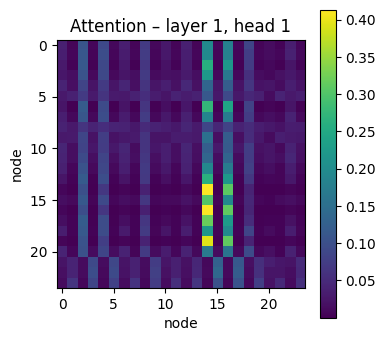

Dominant expert id for each of the 23 nodes:
[5, 2, 2, 5, 2, 4, 5, 2, 2, 3, 5, 1, 5, 3, 2, 5, 2, 5, 2, 3, 5, 4, 1, 1]


In [ ]:
#@title 10. Attention heat-map & expert colours for one event [average running time in google colab for 60 epochs: ~0 sec]

layer = 0        # which transformer layer to inspect
head  = 0        # which attention head (0 … H-1)

# Exercise: write the code to plot the self-attention map of a chosen layer and head, and print the dominant expert selected
# for each node in the event. Follows the description of the functionality of the code available in the text cell above.

# one validation event
sample_x, sample_y = ds_val[0]
sample_x = sample_x.unsqueeze(0).to(device)    # (1,24,1)

# WRITE THE NEEDED CODE HERE ...